`homework_nsmc_251230.ipynb`에 작성하세요. # 95

위 파일을 다운로드 받고, 지침에 따라 감성분석 모델 구현 및 학습/평가/추론 코드를 작성하세요.

# 🧪 실습 가이드: 네이버 영화리뷰 감성분석

## 🎯 실습 목표
- 한글 텍스트 데이터 전처리 과정을 이해한다.
- 토크나이징과 시퀀스 변환의 필요성을 설명할 수 있다.
- PyTorch 기반 감성분석 모델을 구현하고 학습한다.
- 학습된 모델로 문장 감성 추론을 수행한다.
- Embedding Layer의 의미를 시각적으로 이해한다.



In [10]:
# 필요 라이브러리 설치 (필요시 주석 해제)
!pip install konlpy pandas matplotlib torch tqdm

In [11]:
# 라이브러리 임포트

import re
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm  # 진행률 표시바
from collections import Counter
from konlpy.tag import Okt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 시드 고정
torch.manual_seed(42)
np.random.seed(42)

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 01. 데이터 로드

**✅ 실습 과제**
- 네이버 영화 리뷰 데이터셋을 불러온다.
    https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt
- 데이터의 컬럼 구성과 샘플을 확인한다.

**🔍 확인 질문**
1. 리뷰 텍스트와 정답 라벨은 각각 어떤 컬럼에 저장되어 있는가?
2. 긍정 / 부정 라벨은 어떤 값으로 표현되어 있는가?



In [12]:
# ✅ 실습 과제: 데이터 로드

# 1. 데이터 다운로드
url = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt"
urllib.request.urlretrieve(url, filename="ratings.txt")

# 2. 데이터 읽기
df = pd.read_table('data/ratings.txt')

print("전체 데이터 개수:", len(df))
print(df.head())

# 3. 결측치 제거
df = df.dropna(how='any')
print("결측치 제거 후:", len(df))

# 4. (중요) 데이터 셔플링
# 데이터를 섞지 않고 자르면 학습이 제대로 안 될 수 있습니다.
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("데이터 셔플링 완료")

전체 데이터 개수: 200000
         id                                           document  label
0   8112052                                어릴때보고 지금다시봐도 재밌어요ㅋㅋ      1
1   8132799  디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...      1
2   4655635               폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.      1
3   9251303  와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...      1
4  10067386                        안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.      1
결측치 제거 후: 199992
데이터 셔플링 완료


# 2. 데이터 전처리

### 02-01. 한글 전처리

**✅ 실습 과제**
- 특수문자, 숫자, 불필요한 기호를 제거한다.
- 정규표현식을 사용하여 한글만 남긴다.

**🔍 확인 질문**
1. 한글 전처리를 하지 않으면 어떤 문제가 발생할 수 있는가?
2. 감성 분석에서 이모지나 느낌표는 제거하는 것이 항상 옳은가?




In [13]:
# ✅ 실습 과제: 한글 정규화

def clean_text(text):
    # 한글과 공백을 제외하고 모두 제거
    cleaned = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", text)
    return cleaned

# 전처리 적용 (시간이 좀 걸릴 수 있음)
# 전체 데이터에 적용
df['cleaned_document'] = df['document'].apply(clean_text)

# 빈 값 제거 (특수문자만 있던 경우)
df['cleaned_document'] = df['cleaned_document'].str.strip()
df['cleaned_document'].replace('', np.nan, inplace=True)
df = df.dropna(how='any')

print("전처리 후 샘플:")
print(df[['document', 'cleaned_document', 'label']].head())

C:\Users\Playdata\AppData\Local\Temp\ipykernel_24984\2379444416.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cleaned_document'].replace('', np.nan, inplace=True)


전처리 후 샘플:
                                            document  \
0                                     모피너무많이입고나와 불쾌함   
1                     결말이 ㅠ ㅠ 멜비푸포 완전멋져요 ㅠ이제서야알다니 ㅠㅠ   
2                              타케모토 노보루 감독, 최고의 걸작이다   
3    진짜 인생 애니메이션 어릴땐 상상력자극으로 재밌고 커서는 우정간의 감동을 보며 재밌고   
4  몇몇 맞지않는 전개도 있지만 이 정도면 훌륭하다. 우리 이순신장군님 영화도 이렇게 ...   

                                    cleaned_document  label  
0                                     모피너무많이입고나와 불쾌함      0  
1                     결말이 ㅠ ㅠ 멜비푸포 완전멋져요 ㅠ이제서야알다니 ㅠㅠ      1  
2                               타케모토 노보루 감독 최고의 걸작이다      1  
3    진짜 인생 애니메이션 어릴땐 상상력자극으로 재밌고 커서는 우정간의 감동을 보며 재밌고      1  
4  몇몇 맞지않는 전개도 있지만 이 정도면 훌륭하다 우리 이순신장군님 영화도 이렇게 만...      1  


### 02-02. Tokenizing & Sequencing

**✅ 실습 과제**
- Tokenizer를 사용해 단어 사전을 생성한다.
- 문장을 정수 시퀀스로 변환한다.
- padding을 적용하여 시퀀스 길이를 맞춘다.

### 🔍 확인 질문
1. `num_words` 파라미터는 어떤 역할을 하는가?
2. padding을 하지 않으면 배치 학습에서 어떤 문제가 발생하는가?



In [14]:
# ✅ 실습 과제: 토크나이징 및 시퀀스 변환

# 1. 데이터 양 조절 (실습 속도를 위해 3만 개만 사용)
# 전체 데이터를 다 쓰려면 아래 줄을 주석 처리하세요.
limit = 30000
df_subset = df[:limit]
print(f"실습용 데이터 개수: {len(df_subset)}개 (전체 중 일부만 사용)")

X_data = df_subset['cleaned_document'].values
y_data = df_subset['label'].values

# 2. 토크나이징 (Okt)
okt = Okt()
tokenized_data = []

print("형태소 분석 시작 (진행률 표시)...")
for sentence in tqdm(X_data):
    tokenized_data.append(okt.morphs(sentence, stem=True))

print("토크나이징 완료.")

# 3. 단어 사전(Vocab) 생성
vocab_size = 20000
word_counts = Counter()
for sentence in tokenized_data:
    word_counts.update(sentence)

# 빈도수 상위 단어 추출
vocab = sorted(word_counts, key=word_counts.get, reverse=True)[:vocab_size-2]

# 특수 토큰 추가
word_to_index = {'<PAD>': 0, '<OOV>': 1}
for index, word in enumerate(vocab):
    word_to_index[word] = index + 2

index_to_word = {index: word for word, index in word_to_index.items()}
print(f"단어 사전 크기: {len(word_to_index)}")

# 4. 정수 인코딩
X_sequence = []
for sentence in tokenized_data:
    seq = [word_to_index.get(word, 1) for word in sentence]
    X_sequence.append(seq)

# 5. 패딩 (Padding)
max_len = 30  # 문장 최대 길이

def pad_sequences(sequences, max_len, pad_value=0):
    padded_seqs = []
    for seq in sequences:
        if len(seq) < max_len:
            padded_seqs.append(seq + [pad_value] * (max_len - len(seq)))
        else:
            padded_seqs.append(seq[:max_len])
    return np.array(padded_seqs)

X_padded = pad_sequences(X_sequence, max_len=max_len)
y_data = np.array(y_data) # y 데이터도 numpy 배열로 변환

print(f"최종 데이터 형태: X={X_padded.shape}, y={y_data.shape}")

실습용 데이터 개수: 30000개 (전체 중 일부만 사용)
형태소 분석 시작 (진행률 표시)...


100%|██████████| 30000/30000 [02:12<00:00, 226.88it/s]


토크나이징 완료.
단어 사전 크기: 20000
최종 데이터 형태: X=(30000, 30), y=(30000,)


### 02-03. Sequence Decoding

**✅ 실습 과제**
- 정수 시퀀스를 다시 텍스트로 복원해본다.
- 토큰 인덱스와 단어의 매핑 관계를 확인한다.

**🔍 확인 질문**
1. `<OOV>` 토큰은 언제 사용되는가?
2. 디코딩 결과가 원문과 완전히 동일하지 않은 이유는 무엇인가?


In [15]:
# ✅ 실습 과제: 시퀀스 복원 확인

def decode_sequence(sequence):
    decoded = []
    for idx in sequence:
        if idx == 0: continue # 패딩 무시
        decoded.append(index_to_word.get(idx, '<OOV>'))
    return ' '.join(decoded)

print("원본 문장:", X_data[0])
print("정수 시퀀스:", X_padded[0])
print("복원 문장:", decode_sequence(X_padded[0]))

원본 문장: 모피너무많이입고나와 불쾌함
정수 시퀀스: [11298    19   142   821    55    39  1230     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
복원 문장: 모피 너무 많이 입 고 나오다 불쾌하다


## 03. 모델 생성 및 학습

**✅ 실습 과제**
- Embedding Layer를 포함한 감성분석 모델을 정의한다.
- 손실 함수와 옵티마이저를 설정한다.
- 학습 과정을 통해 loss 변화를 확인한다.

**🔍 확인 질문**
1. Embedding Layer는 어떤 역할을 하는가?
2. One-hot 인코딩 대신 Embedding을 사용하는 이유는 무엇인가?



학습 시작...
Epoch [1/5] Loss: 0.6350
Epoch [2/5] Loss: 0.4650
Epoch [3/5] Loss: 0.3645
Epoch [4/5] Loss: 0.2887
Epoch [5/5] Loss: 0.2272


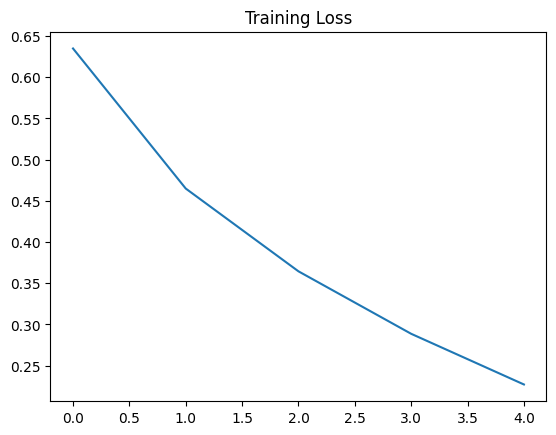

In [16]:
# ✅ 실습 과제: 모델 정의 및 학습

# 1. Dataset 정의
class NSMCDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 데이터 분할 (80% 학습, 20% 검증)
split_idx = int(len(X_padded) * 0.8)
X_train, X_val = X_padded[:split_idx], X_padded[split_idx:]
y_train, y_val = y_data[:split_idx], y_data[split_idx:]

train_ds = NSMCDataset(X_train, y_train)
val_ds = NSMCDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

# 2. 모델 정의 (Embedding -> LSTM -> Linear)
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embed = self.embedding(x)
        output, (hidden, cell) = self.lstm(embed)
        # 마지막 타임스텝의 hidden state 사용
        last_hidden = hidden[-1]
        out = self.fc(last_hidden)
        return self.sigmoid(out)

# 설정
embed_dim = 128
hidden_dim = 128
model = SentimentModel(len(word_to_index), embed_dim, hidden_dim).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. 학습 루프
epochs = 5
train_losses = []

print("학습 시작...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")

plt.plot(train_losses)
plt.title("Training Loss")
plt.show()

## 04. 모델 평가

**✅ 실습 과제**
- 검증 데이터로 모델 성능을 평가한다.
- 정확도(acc)와 손실(loss)을 확인한다.

**🔍 확인 질문**
1. 학습 데이터 성능과 평가 데이터 성능 차이가 의미하는 것은 무엇인가?
2. 과적합 여부는 어떻게 판단할 수 있는가?



In [17]:
# ✅ 실습 과제: 검증 데이터 평가

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            
            # 0.5 기준으로 0 또는 1 예측
            predicted = (outputs >= 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    return correct / total * 100

acc = evaluate(model, val_loader)
print(f"검증 데이터 정확도: {acc:.2f}%")

검증 데이터 정확도: 80.60%


## 05. 모델 추론

**✅ 실습 과제**
- 임의의 문장을 입력하여 감성을 예측한다.
- 출력 확률을 기반으로 긍/부정을 해석한다.

**🔍 확인 질문**
1. 모델 출력값은 확률인가 점수인가?
2. 기준값(threshold)은 왜 필요한가?


In [18]:
# ✅ 실습 과제: 추론 및 디버깅

def predict_sentiment_debug(text, model, word_to_index, max_len):
    model.eval()
    
    # 1. 전처리
    clean_text_val = clean_text(text)
    
    # 2. 토크나이징
    tokens = okt.morphs(clean_text_val, stem=True)
    
    # 3. 시퀀스 변환 (디버깅 정보 포함)
    seq = []
    debug_tokens = []
    for word in tokens:
        idx = word_to_index.get(word, 1) # 없으면 1 (<OOV>)
        seq.append(idx)
        debug_tokens.append(f"{word}({idx})")
    
    # 4. 패딩
    if len(seq) < max_len:
        input_seq = seq + [0] * (max_len - len(seq))
    else:
        input_seq = seq[:max_len]
    
    # 5. 예측
    input_tensor = torch.tensor([input_seq], dtype=torch.long).to(device)
    with torch.no_grad():
        score = model(input_tensor).item()
    
    # 6. 결과 출력
    print(f"입력: {text}")
    print(f"토큰: {debug_tokens}")
    print(f"점수: {score:.4f}")
    if score >= 0.5:
        print(f"결과: 긍정 ({score*100:.2f}%)")
    else:
        print(f"결과: 부정 ({(1-score)*100:.2f}%)")
    print("-" * 40)

# 테스트
predict_sentiment_debug("이 영화 진짜 너무 재밌다! 강추합니다.", model, word_to_index, max_len)
predict_sentiment_debug("돈 아까워 죽는 줄 알았음.. 최악이다.", model, word_to_index, max_len)
predict_sentiment_debug("배우들 연기는 좋은데 스토리가 좀 아쉽네요.", model, word_to_index, max_len)

입력: 이 영화 진짜 너무 재밌다! 강추합니다.
토큰: ['이(2)', '영화(3)', '진짜(28)', '너무(19)', '재밌다(23)', '강(959)', '추하다(1771)']
점수: 0.9898
결과: 긍정 (98.98%)
----------------------------------------
입력: 돈 아까워 죽는 줄 알았음.. 최악이다.
토큰: ['돈(125)', '아깝다(63)', '죽다(258)', '줄(229)', '알다(89)', '최악(111)', '이다(16)']
점수: 0.0125
결과: 부정 (98.75%)
----------------------------------------
입력: 배우들 연기는 좋은데 스토리가 좀 아쉽네요.
토큰: ['배우(61)', '들(11)', '연기(36)', '는(12)', '좋다(17)', '스토리(49)', '가(8)', '좀(73)', '아쉽다(193)']
점수: 0.0878
결과: 부정 (91.22%)
----------------------------------------
